# Imports

In [5]:
!pip install -q gplearn
import warnings
import pandas as pd
import numpy as np
from tqdm import tqdm
import optuna
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import xgboost as xgb
import lightgbm as lgb
from gplearn.genetic import SymbolicTransformer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore") # Because of LGB

---

# Data Visualisation 

In [6]:
import numpy as np
import xgboost as xgb
from tqdm import tqdm

def mice_imputation(df, categorical_cols, numerical_cols, n_imputations=5, max_iter=25, seed=42):
    imputed_dfs = []
    df_encoded = df.copy() 
    missing_cols = df_encoded.columns[df_encoded.isnull().any()].tolist()
    for i in range(n_imputations):
        df_imputed_run = df_encoded.copy()
        for iteration in tqdm(range(max_iter), desc=f"MICE Imputation {i+1}/{n_imputations}"):
            np.random.seed(seed + iteration)
            cols_order = np.random.permutation(missing_cols)
            for target_col in cols_order:
                mask_missing = df_imputed_run[target_col].isnull()
                if mask_missing.sum() == 0:
                    continue
                X_train_cols = df_imputed_run.loc[~mask_missing, df_imputed_run.columns != target_col]
                y_train_col = df_imputed_run.loc[~mask_missing, target_col]
                X_pred_cols = df_imputed_run.loc[mask_missing, df_imputed_run.columns != target_col]
                # Imputation model
                if target_col in categorical_cols:
                    clf = xgb.XGBClassifier(
                        n_estimators=100,
                        tree_method='hist',
                        device='cuda',
                        use_label_encoder=False,
                        eval_metric='mlogloss',
                        random_state=seed
                    )
                    clf.fit(X_train_cols, y_train_col)
                    probabilities = clf.predict_proba(X_pred_cols)
                    imputed_values = np.array([np.random.choice(len(p), p=p) for p in probabilities])
                    df_imputed_run.loc[mask_missing, target_col] = imputed_values.astype(float)
                else:
                    reg = xgb.XGBRegressor(
                        n_estimators=300,
                        tree_method='hist',
                        device='cuda',
                        random_state=seed
                    )
                    reg.fit(X_train_cols, y_train_col)
                    predictions = reg.predict(X_pred_cols)
                    residuals = y_train_col - reg.predict(X_train_cols)
                    noise = np.random.normal(0, np.std(residuals), len(predictions))
                    imputed_values = predictions + noise
                    df_imputed_run.loc[mask_missing, target_col] = imputed_values
        imputed_dfs.append(df_imputed_run)
    return imputed_dfs

# Data Loading
train = pd.read_csv("/kaggle/input/iisc-umc-301-kaggle-competition-1/train.csv")
test  = pd.read_csv("/kaggle/input/iisc-umc-301-kaggle-competition-1/test.csv")
categorical_cols = ['key', 'audio_mode', 'time_signature']
numerical_cols = ['song_duration_ms','acousticness','danceability','energy','instrumentalness','liveness','loudness','speechiness','tempo','audio_valence']
X_train = train.drop(columns=['id', 'song_popularity']).reset_index(drop=True)
y_train = train['song_popularity'].reset_index(drop=True)
X_test  = test.drop(columns=['id']).reset_index(drop=True)
test_id = test['id']

# Run on the data
print("Imputing the train data")
X_train_imputed = mice_imputation(
    df=X_train,
    categorical_cols=categorical_cols,
    numerical_cols=numerical_cols,
    n_imputations=5
)
print("Imputing the test data")
X_test_imputed = mice_imputation(
    df=X_test,
    categorical_cols=categorical_cols,
    numerical_cols=numerical_cols,
    n_imputations=5
)

#Safety check
print(X_train_imputed[0].isna().sum())

Imputing the train data


MICE Imputation 5/5: 100%|██████████| 25/25 [00:06<00:00,  3.65it/s]


Imputing the test data


MICE Imputation 5/5: 100%|██████████| 25/25 [00:05<00:00,  4.20it/s]

song_duration_ms    0
acousticness        0
danceability        0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
audio_mode          0
speechiness         0
tempo               0
time_signature      0
audio_valence       0
dtype: int64


In [7]:
X_train=X_train_imputed[0] # <- Choosing the first one
X_test=X_test_imputed[0]

# Standardising the numbers
scaler = StandardScaler()
X_scaled_train=scaler.fit_transform(X_train)
X_scaled_test=scaler.fit_transform(X_test)
print("Scaling done✅")

Scaling done✅


---

# Checking the separability of the data

In [8]:
# LDA for dimensional separability
lda = LinearDiscriminantAnalysis(n_components=1)
X_lda = lda.fit_transform(X_scaled_train, y_train)
print("LDA 1D separation score:", lda.score(X_scaled_train, y_train))

# PCA explained variance
pca = PCA().fit(X_scaled_train)
print("Cumulative explained variance:", pca.explained_variance_ratio_.cumsum())

LDA 1D separation score: 0.6353666666666666
Cumulative explained variance: [0.22840307 0.33818495 0.4174766  0.49459699 0.56787303 0.63912267
 0.7081291  0.77554685 0.83986757 0.89818629 0.9406184  0.97494047
 1.        ]


---

# We can reduce the dimension to 10 to make the t-SNE graph
Doing this to check for the t-SNE separability graph

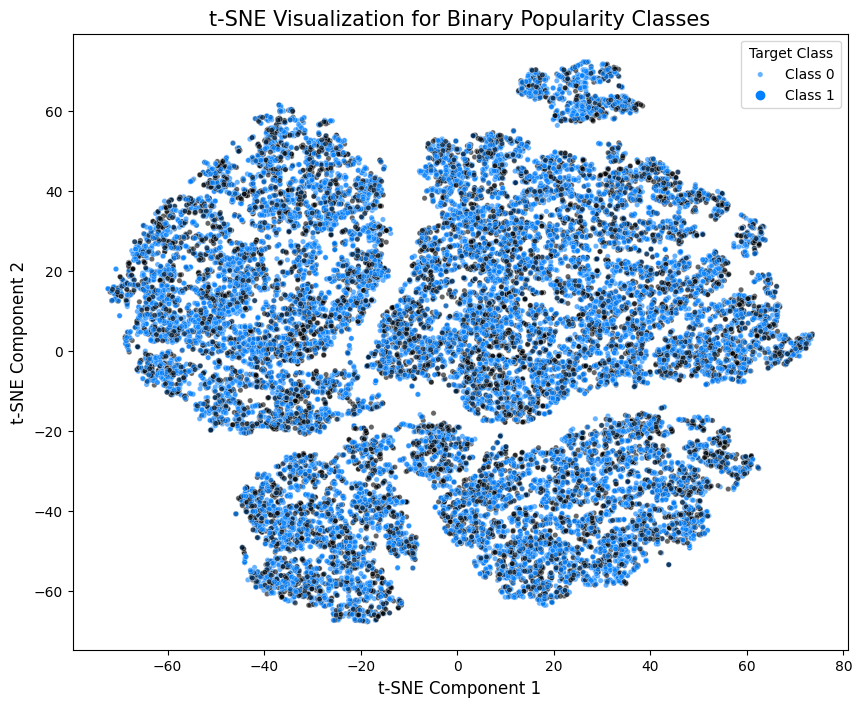

In [9]:
# PCA
pca = PCA(n_components=min(10, X_scaled_train.shape[1]), random_state=42)
X_pca = pca.fit_transform(X_scaled_train)

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000, learning_rate=200)
X_tsne = tsne.fit_transform(X_pca)
tsne_df = pd.DataFrame({
    'TSNE1': X_tsne[:, 0],
    'TSNE2': X_tsne[:, 1],
    'target': y_train.values
})

# Plotting the t-SNE graphs
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=tsne_df,
    x='TSNE1',
    y='TSNE2',
    hue='target',
    palette=['#007fff', '#000000'],  
    alpha=0.6,                       
    s=15                             
)
plt.title('t-SNE Visualization for Binary Popularity Classes', fontsize=15)
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
plt.legend(title='Target Class', labels=['Class 0', 'Class 1'])
plt.show()

---

# Theoretical Separability scores

In [10]:
sil_score = silhouette_score(X_tsne, y_train)
print(f"Silhouette Score: {sil_score:.4f}") # good if >0.5 

db_score = davies_bouldin_score(X_tsne, y_train)
print(f"Davies-Bouldin Index: {db_score:.4f}") # Lower = better

ch_score = calinski_harabasz_score(X_tsne, y_train)
print(f"Calinski-Harabasz Index: {ch_score:.4f}") # Higher = better separation

# Simple linear classifier's seprability on t-SNE output
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
clf = LogisticRegression(max_iter=1000)
auc_scores = cross_val_score(clf, X_tsne, y_train, cv=5, scoring="roc_auc")
print(f"LogReg AUC on t-SNE embeddings: {np.mean(auc_scores):.4f} ± {np.std(auc_scores):.4f}")

Silhouette Score: 0.0001
Davies-Bouldin Index: 47.4958
Calinski-Harabasz Index: 10.7956
LogReg AUC on t-SNE embeddings: 0.5111 ± 0.0100


---

# The data is not so separable

---

In [11]:
column_names = ['song_duration_ms', 'acousticness', 'danceability', 'energy','instrumentalness', 'key', 'liveness', 'loudness', 'audio_mode','speechiness', 'tempo', 'time_signature', 'audio_valence']
X_train_df = pd.DataFrame(X_scaled_train, columns=column_names)
X_test_df = pd.DataFrame(X_scaled_test, columns=column_names)
numerical_columns=['song_duration_ms', 'acousticness', 'danceability', 'energy','instrumentalness', 'liveness', 'loudness' ,'speechiness', 'tempo', 'audio_valence']
categorical_columns=['key','time_signature','audio_mode']

---

# Feature Engineering using GP

In [12]:
X_train_numeric = X_train_df[column_names].values
X_test_numeric = X_test_df[column_names].values

# GP Generator for EO based feature engineering
gp = SymbolicTransformer(
    generations=10,
    population_size=1000,
    hall_of_fame=100,
    n_components=10,
    function_set=['add', 'sub', 'mul', 'div', 'sqrt', 'log', 'abs', 'neg', 'inv', 'max', 'min'], #<- No exp or inv_tan due to data type
    parsimony_coefficient=0.001,
    max_samples=0.9,
    verbose=1,
    random_state=42,
    metric='pearson'
)

# Fit GP to training data
gp.fit(X_train_numeric, y_train)

X_train_gp = gp.transform(X_train_numeric)
X_test_gp = gp.transform(X_test_numeric)

# Only take the top 10 progeny
top_k = 10  
selector = SelectKBest(f_classif, k=top_k)
X_train_gp_selected = selector.fit_transform(X_train_gp, y_train)
X_test_gp_selected = selector.transform(X_test_gp)

# combine
X_train_aug = np.hstack([X_train_numeric, X_train_gp_selected])
X_test_aug = np.hstack([X_test_numeric, X_test_gp_selected])

print(X_train_aug.shape, X_test_aug.shape)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    10.60        0.0128892        5        0.0617101        0.0590096     28.99s
   1     4.80        0.0330483        6        0.0700847         0.097409     19.95s
   2     3.74        0.0461845        7        0.0762488        0.0638668     16.80s
   3     5.06        0.0511321       10        0.0817537        0.0788337     14.86s
   4     6.33        0.0578727       13        0.0852662         0.109367     13.51s
   5     7.45        0.0605488       12        0.0894231        0.0570419     10.93s
   6     8.60        0.0609689       14        0.0918594        0.0834779      8.53s
   7    10.22        0.0618448       14        0.0929494        0.0732057      5.91s
   8    11.37        0.0626548       13        0.0927727        0.0404423  

In [15]:
# Naming the new columns
gp_feature_names = [f"col_gp_{i+1}" for i in range(X_train_gp_selected.shape[1])]

# Combine the columns 
all_feature_names = column_names + gp_feature_names

# Train and test DataFrames
X_train_aug_df = pd.DataFrame(data = np.hstack([X_train_numeric, X_train_gp_selected]), columns = all_feature_names)
X_test_aug_df = pd.DataFrame(data = np.hstack([X_test_numeric, X_test_gp_selected]), columns = all_feature_names)

# Compute f_classif scores for all columns
f_scores, p_values = f_classif(X_train_aug_df, y_train)

# View
feature_scores_df = pd.DataFrame({
    "feature": all_feature_names,
    "f_score": f_scores,
    "p_value": p_values
}).sort_values(by="f_score", ascending=False)
print(feature_scores_df)

# Finall Dfs to train on
X_train=X_train_aug_df[all_feature_names]
X_test=X_test_aug_df[all_feature_names]
print(X_train.shape)

             feature     f_score       p_value
13          col_gp_1  250.442857  3.511169e-56
16          col_gp_4  225.849777  7.341637e-51
14          col_gp_2  224.356387  1.545541e-50
17          col_gp_5  224.288400  1.598817e-50
22         col_gp_10  222.039889  4.904604e-50
20          col_gp_8  218.770689  2.503183e-49
19          col_gp_7  218.731336  2.552788e-49
18          col_gp_6  211.960106  7.474915e-48
21          col_gp_9  209.993770  1.993425e-47
15          col_gp_3  209.852134  2.139371e-47
3             energy   91.828639  1.015376e-21
12     audio_valence   64.254593  1.132790e-15
7           loudness   56.312314  6.353971e-14
1       acousticness   19.181422  1.192669e-05
9        speechiness   14.157644  1.684325e-04
2       danceability    9.039826  2.643794e-03
11    time_signature    8.134042  4.347146e-03
10             tempo    8.116762  4.388766e-03
6           liveness    4.037085  4.451958e-02
5                key    3.680871  5.504957e-02
4   instrumen

# *We keep all the columns irrespective of this F-score, removing them does not decrease the noise*

---

# Checking the separability again

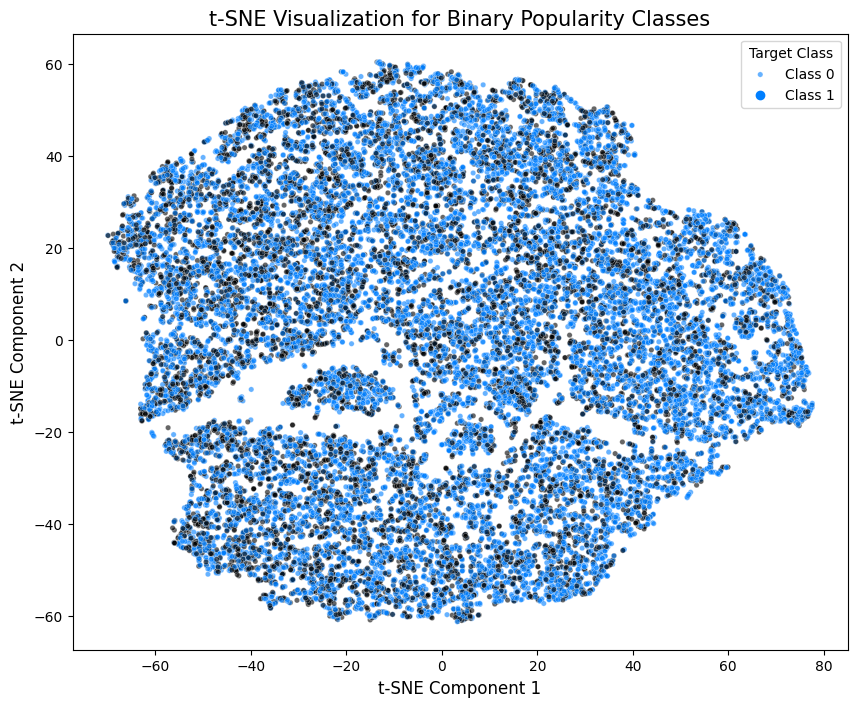

In [16]:
# PCA
pca = PCA(n_components=min(10, X_train.shape[1]), random_state=42)
X_pca = pca.fit_transform(X_train)

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000, learning_rate=200)
X_tsne = tsne.fit_transform(X_pca)

tsne_df = pd.DataFrame({
    'TSNE1': X_tsne[:, 0],
    'TSNE2': X_tsne[:, 1],
    'target': y_train.values
})

# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=tsne_df,
    x='TSNE1',
    y='TSNE2',
    hue='target',
    palette=['#007fff', '#000000'],  
    alpha=0.6,                       
    s=15                            
)
plt.title('t-SNE Visualization for Binary Popularity Classes', fontsize=15)
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
plt.legend(title='Target Class', labels=['Class 0', 'Class 1'])
plt.show()

---

# 1. XGBoost

In [17]:
def objective_xgb(trial, X, y):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 20, 2000, log=True),
        "verbosity": 0,
        "lambda": trial.suggest_float("lambda", 1e-5, 100.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-5, 100.0, log=True),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "min_child_weight": trial.suggest_float("min_child_weight", 1e-5, 100, log=True),
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.2, log=True),
        "gamma": trial.suggest_float("gamma", 1e-5, 1.0, log=True),
        "tree_method": "hist",
        "eval_metric": "auc",
        "device" : "cuda",
        "use_label_encoder": False
    }
    clf = xgb.XGBClassifier(**params)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(clf, X, y, cv=skf, scoring='roc_auc')
    return score.mean()
X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy().ravel()
study_xgb = optuna.create_study(direction="maximize")
study_xgb.optimize(lambda trial: objective_xgb(trial, X_train_np, y_train_np), n_trials=5, show_progress_bar=True)
best_params_xgb = study_xgb.best_trial.params
clf_xgb = xgb.XGBClassifier(**best_params_xgb, tree_method="hist", use_label_encoder=False)
clf_xgb.fit(X_train_np, y_train_np, eval_metric="auc")
clf_xgb_cal = CalibratedClassifierCV(clf_xgb, method='isotonic', cv=5)
clf_xgb_cal.fit(X_train_np, y_train_np)
y_pred_xgb_cal = clf_xgb_cal.predict_proba(X_test.to_numpy())[:,1]
print("XGB done:✅")

[I 2025-10-05 04:15:50,261] A new study created in memory with name: no-name-23411fad-669f-43dd-b708-9f0ddfff1d50


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2025-10-05 04:15:53,429] Trial 0 finished with value: 0.5651581175373976 and parameters: {'n_estimators': 544, 'lambda': 0.006530922423467554, 'alpha': 17.458384006467522, 'colsample_bytree': 0.8397379249534764, 'max_depth': 3, 'min_child_weight': 0.00033819709905024504, 'learning_rate': 0.09837826836220935, 'gamma': 2.8847282009520682e-05}. Best is trial 0 with value: 0.5651581175373976.
[I 2025-10-05 04:15:56,337] Trial 1 finished with value: 0.5469787645492922 and parameters: {'n_estimators': 126, 'lambda': 0.5666354691339343, 'alpha': 2.715192482988767, 'colsample_bytree': 0.2906665450958178, 'max_depth': 8, 'min_child_weight': 0.11756475810434949, 'learning_rate': 0.09208557588357374, 'gamma': 0.001714756799080457}. Best is trial 0 with value: 0.5651581175373976.
[I 2025-10-05 04:16:09,570] Trial 2 finished with value: 0.5396970851315663 and parameters: {'n_estimators': 1320, 'lambda': 0.264600152982216, 'alpha': 0.0014052556226626116, 'colsample_bytree': 0.6386352182809503, 'm

---

# 2: LGBoost

In [18]:
def objective_lgb(trial, X, y):
    params = {
        "objective": "binary",
        "metric": "auc",
        "device": "gpu", 
        "verbose": -1, 
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart"]),
        "n_estimators":trial.suggest_int("n_estimators", 100, 500, log=True),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-3, 100.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-3, 100.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 16, 256, step=16),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 12)
    }
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    aucs = []
    for train_idx, valid_idx in skf.split(X, y):
        X_tr, X_val = X[train_idx], X[valid_idx]
        y_tr, y_val = y[train_idx], y[valid_idx]
        clf = lgb.LGBMClassifier(**params)
        clf.fit(X_tr, y_tr, 
                eval_set=[(X_val, y_val)], 
                eval_metric="auc",
                callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)])
        aucs.append(roc_auc_score(y_val, clf.predict_proba(X_val)[:, 1]))
    return np.mean(aucs)

study_lgb = optuna.create_study(direction="maximize")
study_lgb.optimize(lambda trial: objective_lgb(trial, X_train_np, y_train_np), n_trials=5, show_progress_bar=True)
best_params_lgb = study_lgb.best_trial.params
best_params_lgb["verbose"] = -1 
clf_lgb = lgb.LGBMClassifier(**best_params_lgb, device="gpu")
clf_lgb.fit(X_train_np, y_train_np, eval_set=[(X_train_np, y_train_np)], eval_metric="auc",callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)])
clf_lgb_cal = CalibratedClassifierCV(clf_lgb, method='isotonic', cv=5)
clf_lgb_cal.fit(X_train_np, y_train_np)
y_pred_lgb_cal = clf_lgb_cal.predict_proba(X_test.to_numpy())[:, 1]
print("LGM done:✅")

[I 2025-10-05 04:16:47,113] A new study created in memory with name: no-name-0f6783bc-0ede-4454-9af6-3104caa84d4c


  0%|          | 0/5 [00:00<?, ?it/s]

1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


[I 2025-10-05 04:17:01,706] Trial 0 finished with value: 0.5653070818783819 and parameters: {'boosting_type': 'dart', 'n_estimators': 149, 'lambda_l1': 0.0023945255949403745, 'lambda_l2': 17.344160893671493, 'num_leaves': 160, 'feature_fraction': 0.5700972467979384, 'bagging_fraction': 0.5017318934519974, 'bagging_freq': 4, 'min_child_samples': 85, 'learning_rate': 0.10028582073125557, 'max_depth': 7}. Best is trial 0 with value: 0.5653070818783819.
[I 2025-10-05 04:17:04,107] Trial 1 finished with value: 0.5618697543747173 and parameters: {'boosting_type': 'gbdt', 'n_estimators': 266, 'lambda_l1': 0.12761704076353272, 'lambda_l2': 0.14121024514159114, 'num_leaves': 32, 'feature_fraction': 0.9482728059071706, 'bagging_fraction': 0.5063977180923197, 'bagging_freq': 5, 'min_child_samples': 97, 'learning_rate': 0.20699968372779268, 'max_depth': 6}. Best is trial 0 with value: 0.5653070818783819.
[I 2025-10-05 04:17:09,476] Trial 2 finished with value: 0.5726029798167749 and parameters: {'

---

# Ensembling -> Normal average

In [19]:
probs = [np.array(y_pred_xgb_cal), np.array(y_pred_lgb_cal)]
y_pred_ensemble = np.mean(probs, axis=0)
print("Ensemble probabilities shape:", y_pred_ensemble.shape)
submission_df = pd.DataFrame({"id": test_id,"song_popularity": y_pred_ensemble})
submission_df.to_csv("submission_final.csv", index=False)
print("Submission file saved as 'submission_final.csv'")

Ensemble probabilities shape: (10000,)
Submission file saved as 'submission_final.csv'
